In [4]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

In [5]:
cifar10_builder = tfds.builder("cifar10")

In [6]:
cifar10_builder.download_and_prepare()

/Users/j.babcock/Library/Python/3.7/lib/python/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /Users/j.babcock/tensorflow_datasets/cifar10/3.0.0.incompleteFV44SL/cifar10-train.tfrecord


Shuffling and writing examples to /Users/j.babcock/tensorflow_datasets/cifar10/3.0.0.incompleteFV44SL/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /Users/j.babcock/tensorflow_datasets/cifar10/3.0.0. Subsequent calls will reuse this data.


In [115]:
cifar10_train = cifar10_builder.as_dataset(split="train")
cifar10_test = cifar10_builder.as_dataset(split="test")

In [251]:
cifar10_train.take(1)

<DatasetV1Adapter shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [211]:
class VAE(tf.keras.Model):
    
    def __init__(self, input_shape, name='variational_autoencoder',
                 latent_dim=10, hidden_dim=10, encoder='GaussianMLP', 
                 decoder='BernoulliMLP', iaf_model=None,
                 number_iaf_networks=0,
                 iaf_params={},
                 num_samples=100, **kwargs):
        super().__init__(name=name, **kwargs)
        self._latent_dim = latent_dim
        self._num_samples = num_samples
        self._iaf = []
        
        if encoder == 'GaussianMLP':
            self._encoder = GaussianMLP(input_shape=input_shape, 
                                        latent_dim=latent_dim, 
                                        iaf=(iaf_model is not None), 
                                        hidden_dim=hidden_dim)
        else:
            raise ValueError("Unknown encoder type: {}".format(encoder))
        
        if decoder == 'BernoulliMLP':
            self._decoder = BernoulliMLP(input_shape=(1,latent_dim), latent_dim=input_shape[1], 
                                         hidden_dim=hidden_dim)
        elif decoder == 'GaussianMLP':
            self._encoder = GaussianMLP(input_shape=(1,latent_dim), 
                                        latent_dim=input_shape[1], 
                                        iaf=(iaf_model is not None), 
                                        hidden_dim=hidden_dim)
        else:
            raise ValueError("Unknown decoder type: {}".format(decoder))
        
        if iaf_model:
            self._iaf = []
            for t in range(number_iaf_networks):
                self._iaf.append(
                    iaf_model(input_shape==(1,latent_dim*2), **iaf_params)
                )
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(self._num_samples, self.latent_dim))
        return self._decoder.call(eps, apply_sigmoid=False)

    def encode(self, x):
        return self._encoder.call(x)
    
    def decode(self, z, apply_sigmoid=False):
        logits, _, _ = self._decoder.call(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
    
        return logits
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    
    @property
    def iaf(self):
        return self._iaf
    
    

In [309]:
#model = VAE(input_shape=(1,3072))


model = VAE(input_shape=(1,3072), hidden_dim=500, latent_dim=500, iaf_model=GaussianMLP, number_iaf_networks=3, 
            iaf_params={'latent_dim': 500, 'hidden_dim': 500, 'iaf': False})


In [310]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
          -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar, h = model.encode(x)
    z = model.reparameterize(mean, logvar)
    
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    for iaf_model in model.iaf:
        mean, logvar, _ = iaf_model.call(tf.concat([z, h], 2))
        s = tf.sigmoid(logvar)
        z = tf.add(tf.math.multiply(z,s), tf.math.multiply(mean,(1-s)))
        logqz_x -= tf.reduce_sum(tf.math.log(s))
    
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[2])
    logpz = log_normal_pdf(z, 0., 0.)
          
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [311]:
import time as time
epochs = 100

optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in cifar10_train.map(
            lambda x: flatten_image(x, label=False)).batch(32):
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in cifar10_test.map(
            lambda x: flatten_image(x, label=False)).batch(32):
            loss(compute_loss(model, test_x))
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))

Epoch: 1, Test set ELBO: -2151.757080078125, time elapse for current epoch 61.974515199661255
Epoch: 2, Test set ELBO: -2061.24560546875, time elapse for current epoch 58.04972314834595
Epoch: 3, Test set ELBO: -2038.94970703125, time elapse for current epoch 60.04802680015564
Epoch: 4, Test set ELBO: -2026.10546875, time elapse for current epoch 60.26771402359009
Epoch: 5, Test set ELBO: -2018.3909912109375, time elapse for current epoch 58.40106797218323
Epoch: 6, Test set ELBO: -2013.5391845703125, time elapse for current epoch 58.88316321372986
Epoch: 7, Test set ELBO: -2009.5238037109375, time elapse for current epoch 58.35735893249512
Epoch: 8, Test set ELBO: -2005.8297119140625, time elapse for current epoch 60.940675020217896
Epoch: 9, Test set ELBO: -2003.8834228515625, time elapse for current epoch 59.65025997161865
Epoch: 10, Test set ELBO: -2002.408203125, time elapse for current epoch 61.06896686553955
Epoch: 11, Test set ELBO: -2001.0401611328125, time elapse for current 

KeyboardInterrupt: 

Cause: could not parse the source code:

for sample in cifar10_train.map(lambda x: flatten_image(x, label=False)).batch(1).take(3):

This error may be avoided by creating the lambda in a standalone statement.



Cause: could not parse the source code:

for sample in cifar10_train.map(lambda x: flatten_image(x, label=False)).batch(1).take(3):

This error may be avoided by creating the lambda in a standalone statement.



Cause: could not parse the source code:

for sample in cifar10_train.map(lambda x: flatten_image(x, label=False)).batch(1).take(3):

This error may be avoided by creating the lambda in a standalone statement.



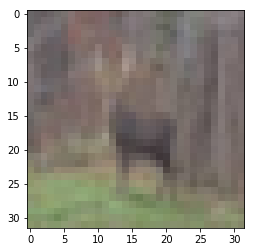

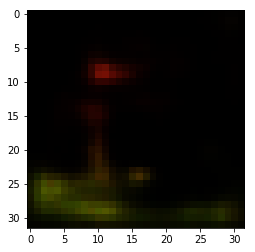

In [347]:
for sample in cifar10_train.map(lambda x: flatten_image(x, label=False)).batch(1).take(3):
    mean, logvar, h = model.encode(sample)
    z = model.reparameterize(mean, logvar)
    
    for iaf_model in model.iaf:
        mean, logvar, _ = iaf_model.call(tf.concat([z, h], 2))
        s = tf.sigmoid(logvar)
        z = tf.add(tf.math.multiply(z,s), tf.math.multiply(mean,(1-s)))    
    
    plt.figure(0)
    plt.imshow((sample.numpy().reshape(32,32,3)).astype(np.float32), 
               cmap=plt.get_cmap("gray")
              )
    
    plt.figure(1)
    plt.imshow((model.decode(z).numpy().reshape(32,32,3)).astype(np.float32), 
               cmap=plt.get_cmap("gray")
              )

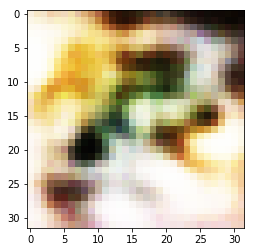

In [360]:
z = np.random.normal(size=(1,500))
h = np.random.normal(size=(1,500))

for iaf_model in model.iaf:
    mean, logvar, _ = iaf_model.call(tf.concat([z, h], 1))
    s = tf.sigmoid(logvar)
    z = tf.add(tf.math.multiply(z,s), tf.math.multiply(mean,(1-s)))    
    
plt.imshow((model.decode(z).numpy().reshape(32,32,3)).astype(np.float32), 
               cmap=plt.get_cmap("gray")
              )

In [352]:
import tensorflow_probability as tfp

class GaussianMLP(tf.keras.Model):
    
    def __init__(self, input_shape, name='GaussianMLP', hidden_dim=10, latent_dim=10, iaf=False, **kwargs):
        super().__init__(name=name, **kwargs)
        self._h = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self._mean = tf.keras.layers.Dense(latent_dim)
        self._logvar = tf.keras.layers.Dense(latent_dim)
        self._iaf_output = None
        if iaf:
            self._iaf_output = tf.keras.layers.Dense(latent_dim)
    
    def call(self, x):
        if self._iaf_output:
            return self._mean(self._h(x)), self._logvar(self._h(x)), self._iaf_output(self._h(x))
        else:
            return self._mean(self._h(x)), self._logvar(self._h(x)), None
        
        
        

In [102]:
class BernoulliMLP(tf.keras.Model):
    
    def __init__(self, input_shape, name='BernoulliMLP', hidden_dim=10, latent_dim=10, **kwargs):
        super().__init__(name=name, **kwargs)
        
        self._h = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self._y = tf.keras.layers.Dense(latent_dim, activation='sigmoid')
        
    def call(self, x):
        
        return self._y(self._h(x)), None, None

In [100]:
g = GaussianMLP(input_shape=(1,3072), hidden_dim=10, latent_dim=10)

In [103]:
b = BernoulliMLP(input_shape=(1,3072), hidden_dim=10, latent_dim=10)

In [107]:
for image in cifar10_train.map(lambda x: flatten_image(x, label=False)).take(10):
    print(g.call(image))

(<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.9138231 ,  1.3610146 ,  0.23907232,  0.16107902, -0.3204968 ,
        -0.12370022, -0.07392889, -0.21223463, -1.1284611 , -0.7407988 ]],
      dtype=float32)>, <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.58465874, -0.98644125,  0.25150728,  0.13377059,  0.8031167 ,
        -0.39094824,  0.47175738,  1.2320937 , -0.76058424,  0.04705095]],
      dtype=float32)>)
(<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.7726524 ,  1.0338037 , -0.0197671 ,  0.18892278,  0.16921538,
        -0.3977122 , -0.29456812,  0.17124416, -1.0118    , -0.9429607 ]],
      dtype=float32)>, <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.02545422, -0.53877133,  0.25475597,  0.18296069,  0.40710446,
        -0.52339756,  0.05319175,  1.2576697 , -0.90236217,  0.58443266]],
      dtype=float32)>)
(<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-1.028199  ,  1.0030779 ,  0.26368058,  0.14021245, -0.05540

In [85]:
!pip3 install pydot
!pip3 install graphviz

In [74]:
import pydot
import graphviz

In [75]:

tf.keras.utils.plot_model(g)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [11]:
def flatten_image(x, label=False):
    if label:
        return (tf.divide(
            tf.dtypes.cast(
                tf.reshape(x["image"], (1, 32*32*3)), tf.float32), 256.0),
                x["label"])
    else:
        return (
            tf.divide(tf.dtypes.cast(
                tf.reshape(x["image"], (1, 32*32*3)), tf.float32), 256.0))

Cause: could not parse the source code:

for sample in cifar10_train.map(lambda x: flatten_image(x, label=True)).take(1):

This error may be avoided by creating the lambda in a standalone statement.



Cause: could not parse the source code:

for sample in cifar10_train.map(lambda x: flatten_image(x, label=True)).take(1):

This error may be avoided by creating the lambda in a standalone statement.



Cause: could not parse the source code:

for sample in cifar10_train.map(lambda x: flatten_image(x, label=True)).take(1):

This error may be avoided by creating the lambda in a standalone statement.

(<tf.Tensor: shape=(1, 3072), dtype=float32, numpy=
array([[0.55859375, 0.375     , 0.2734375 , ..., 0.86328125, 0.73046875,
        0.61328125]], dtype=float32)>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)
Label: 7


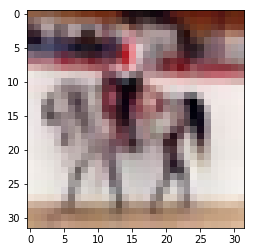

In [31]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for sample in cifar10_train.map(lambda x: flatten_image(x, label=True)).take(1):
    plt.imshow(sample[0].numpy().reshape(32,32,3).astype(np.float32), 
               cmap=plt.get_cmap("gray")
              )
    print("Label: %d" % sample[1].numpy())